# Uber & Lyft Trip Duration Prediction with LightGBM and Optuna

## Introduction

This notebook builds upon the initial analysis, incorporating data cleaning (outlier removal) and feature engineering to train a LightGBM model. The target variable, `duration`, is log-transformed to handle its skewed distribution. We use Optuna to find the best hyperparameters for the model.

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from typing import Tuple
import optuna
from tqdm.notebook import tqdm
import warnings

optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings("ignore", category=UserWarning)

/home/miessigomes/anaconda3/envs/kaggle_challenge/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Loading and Cleaning

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print('Train Data Shape:', train_df.shape)
print('Test Data Shape:', test_df.shape)

train_df.head()

Train Data Shape: (146001, 7)
Test Data Shape: (30000, 6)


,row_id,start_lng,start_lat,end_lng,end_lat,datetime,duration
0,0,-73.783279,40.644718,-73.963799,40.681320,2015-01-09 00:51:48,1815.0
1,1,-122.422385,37.789408,-122.419890,37.766692,2012-09-14 01:46:00,300.0
2,2,-73.885292,40.773060,-74.000076,40.761360,2015-04-19 20:26:57,2620.0
3,3,-122.401603,37.788975,-122.410958,37.796447,2012-09-03 23:48:00,360.0
4,4,-74.008728,40.714317,-74.006432,40.731720,2015-01-21 12:14:45,582.0


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146001 entries, 0 to 146000
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   row_id     146001 non-null  int64  
 1   start_lng  145601 non-null  float64
 2   start_lat  146001 non-null  float64
 3   end_lng    146001 non-null  float64
 4   end_lat    145401 non-null  float64
 5   datetime   146001 non-null  object 
 6   duration   146001 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 7.8+ MB


In [4]:
train_df.describe()

,row_id,start_lng,start_lat,end_lng,end_lat,duration
count,146001.000000,145601.000000,146001.000000,146001.000000,145401.000000,146001.000000
mean,73000.000000,-86.465695,39.913703,-87.177163,39.922772,1063.222314
std,42147.002663,25.468467,1.339508,22.225753,1.336437,3305.905829
min,0.000000,-122.515832,37.459648,-122.634420,37.225640,0.000000
25%,36500.000000,-122.393532,37.798430,-122.392458,37.800318,382.000000
50%,73000.000000,-73.989830,40.741089,-73.988754,40.740990,631.000000
75%,109500.000000,-73.974190,40.762104,-73.971245,40.762669,1020.000000
max,146000.000000,74.100212,40.994354,-50.336068,41.005390,42168.000000


### Duration (variável alvo):
    * Média: 1063.22 segundos (aprox. 17 min).
    * Desvio padrão: 3305.91, bem alto, indicando muita dispersão.
    * Mínimo: 0.0 (pode ser um erro ou outlier).
    * Máximo: 42168.0 segundos (quase 12 horas), também um possível outlier.
    * Distribuição: assimétrica, com muitos valores pequenos e poucos muito altos (indicação de skewness).

### Coordenadas geográficas (start_lng, start_lat, end_lng, end_lat):
    * Valores que parecem abranger várias regiões, incluindo coordenadas muito extremas por exemplo, end_lng vai até 74.100212.
    * Pode haver registros fora da área esperada (como viagens com longitude positiva ou latitude fora do normal).
    * Esses outliers podem afetar a modelagem e precisam ser investigados ou removidos.

In [5]:
# 1. Remove null values
train_df.dropna(inplace=True)

# 2. Remove trips with zero duration
train_df = train_df[train_df['duration'] > 0]

# 3. Remove outliers based on the 99th percentile
upper_limit = train_df['duration'].quantile(0.99)
train_df = train_df[train_df['duration'] <= upper_limit]

print(f"Shape of cleaned training data: {train_df.shape}")

Shape of cleaned training data: (143056, 7)


### Distribution of Trip Duration after Cleaning

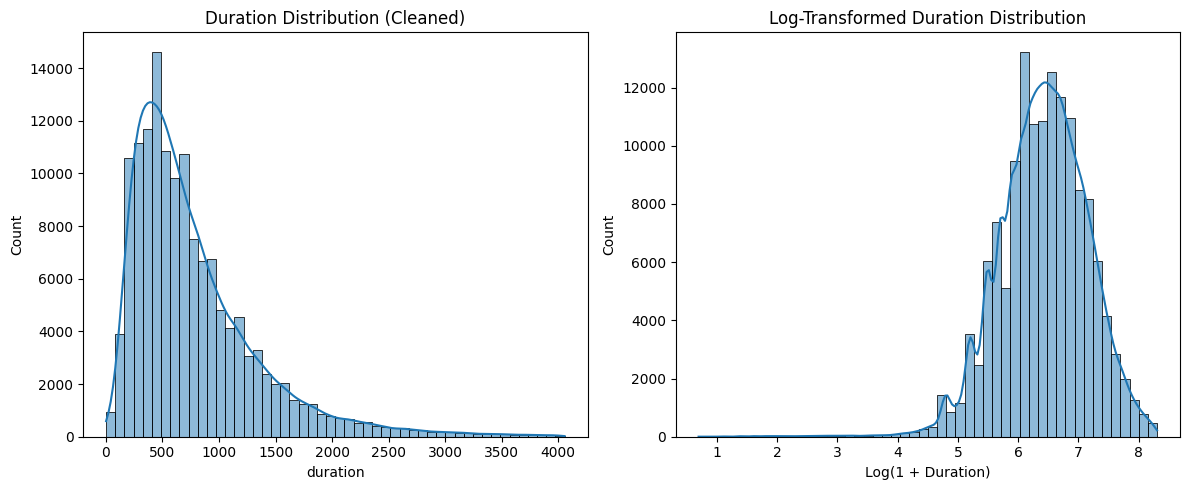

In [6]:
plt.figure(figsize=(12, 5))

# Before transformation
plt.subplot(1, 2, 1)
sns.histplot(train_df['duration'], bins=50, kde=True)
plt.title('Duration Distribution (Cleaned)')

# After transformation
plt.subplot(1, 2, 2)
sns.histplot(np.log1p(train_df['duration']), bins=50, kde=True)
plt.title('Log-Transformed Duration Distribution')
plt.xlabel('Log(1 + Duration)')

plt.tight_layout()
plt.show()

#### Normalmente, queremos reduzir a assimetria positiva, pois ela pode atrapalhar modelos de regressão, especialmente os lineares.

---

#### LightGBM lida muito bem com distribuições assimétricas, sejam elas positivas ou negativas.
Por quê?
 Porque o LightGBM é baseado em árvores de decisão, e:

    Árvores não assumem distribuições específicas dos dados;

    Elas dividem os dados em thresholds, não importando a forma da distribuição, ou seja, não precisam que os dados sejam normalizados ou simétricos.

## Feature Engineering

### Por que é preciso criar essa função ?

  O objetivo do desafio é prever a duração de uma viagem. Um dos fatores que mais
  influenciam a duração é, obviamente, a distância a ser percorrida.

  No entanto, os dados que temos não fornecem a distância diretamente. Em vez
  disso, temos as coordenadas geográficas (latitude e longitude) do ponto de
  partida e de chegada.

  É aqui que a função haversine_distance entra:

   1. Calcular a Distância: Ela implementa a fórmula de Haversine, que calcula a
      distância em linha reta entre dois pontos na superfície da Terra, levando em
      conta a curvatura do planeta. Isso nos dá a distância "aérea" entre o início e o fim da viagem.
   2. Criar uma Nova Feature: O resultado desse cálculo é usado para criar uma nova
      coluna no DataFrame chamada distance.
   3. Melhorar o Modelo: Essa nova feature (distance) é extremamente valiosa para o
      modelo de machine learning. Em vez de o modelo ter que aprender a complexa
      relação entre quatro colunas de coordenadas para estimar o tempo, ele pode usar
       uma única feature muito mais informativa e diretamente correlacionada com a
      duração.

  Em resumo, a função é necessária para traduzir as coordenadas geográficas em 
  uma feature de distância que o modelo possa usar para fazer previsões mais 
  precisas.


In [7]:
def haversine_distance(lat1: float, lon1: float, lat2: float, lon2: float) -> float:
    R = 6371  # Earth radius in kilometers
    lat1_rad, lon1_rad, lat2_rad, lon2_rad = map(np.radians, [lat1, lon1, lat2, lon2])
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

def create_features(df: pd.DataFrame) -> pd.DataFrame:
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['hour'] = df['datetime'].dt.hour
    df['day_of_week'] = df['datetime'].dt.dayofweek
    df['month'] = df['datetime'].dt.month
    df['year'] = df['datetime'].dt.year
    df['distance'] = haversine_distance(df['start_lat'], df['start_lng'], df['end_lat'], df['end_lng'])
    return df

train_df = create_features(train_df)
test_df = create_features(test_df)

## Hyperparameter Tuning with Optuna

In [8]:
features = ['start_lng', 'start_lat', 'end_lng', 'end_lat', 'hour', 'day_of_week', 'month', 'year', 'distance']
target = 'duration'

X = train_df[features]
y = np.log1p(train_df[target]) # Log-transform the target variable

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
def objective(trial):
    params = {
        'objective': 'regression_l1',
        'metric': 'rmse',
        'n_estimators': 300,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 31, 128),
        'verbose': -1,
        'n_jobs': -1,
        'seed': 42,
        'boosting_type': 'gbdt',
    }

    model = lgb.LGBMRegressor(**params)

    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(30, verbose=False)],
    )

    preds = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    return rmse

In [10]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20, show_progress_bar=True)

Best trial: 19. Best value: 0.366782: 100%|██████████| 20/20 [00:25<00:00,  1.27s/it]


## Model Training with Best Hyperparameters

In [11]:
print(f'Best RMSE (log): {study.best_value:.4f}')
print('Best parameters:')
print(study.best_trial.params)

Best RMSE (log): 0.3668
Best parameters:
{'learning_rate': 0.09979706574824286, 'feature_fraction': 0.7067668532162426, 'bagging_fraction': 0.601844190303409, 'bagging_freq': 3, 'lambda_l1': 7.742095563863441, 'lambda_l2': 7.256182338523727e-08, 'num_leaves': 127}


In [12]:
best_params = study.best_trial.params
best_params.update(
    {
        'objective': 'regression_l1',
        'metric': 'rmse',
        'n_estimators': 1000,
        'verbose': -1,
        'n_jobs': -1,
        'seed': 42,
        'boosting_type': 'gbdt',
    }
)

final_model = lgb.LGBMRegressor(**best_params)
final_model.fit(X, y)

,boosting_type,'gbdt'
,num_leaves,127
,max_depth,-1
,learning_rate,0.09979706574824286
,n_estimators,1000
,subsample_for_bin,200000
,objective,'regression_l1'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


## Prediction and Submission

In [13]:
X_test = test_df[features]

test_predictions_log = final_model.predict(X_test)

# Revert predictions to original scale due to log1p transformation
test_predictions = np.expm1(test_predictions_log)

# Ensure predictions are non-negative
test_predictions[test_predictions < 0] = 0

submission_df = pd.DataFrame({'row_id': test_df['row_id'], 'duration': test_predictions})
submission_df.to_csv('submission_optuna.csv', index=False)

## Top 10 Predictions

In [14]:
submission_df.head(10)

,row_id,duration
0,0,1116.227695
1,1,338.769171
2,2,1704.990357
3,3,504.052298
4,4,1171.977858
5,5,605.687210
6,6,821.865430
7,7,435.747735
8,8,1369.726156
9,9,1274.061881
